In [1]:
# this enable automatic reloading of libraries
%load_ext autoreload
%autoreload 2

# import libraries
import numpy as np
import matplotlib.pyplot as plt
from clib.geolocation_1Dv import *

In [2]:
### création de la source (vitesse de 2.5 m/s)
sources=[]
sources.append(source( 0.e3, 0, v_x = 2.5))
Ns = len(sources)

### création du récepeur (vitesse de 10cm/s)
r=receiver(5.e3, 0, e_x=10.e3, e_dt=0.005, v_x= 0.1)

### initialisation du mapping
pmap = xtmap(c_b=1500., e_t=0.007) 

In [4]:
t_e = np.arange(0.,3600.,1.*60.)
print(t_e)

[   0.   60.  120.  180.  240.  300.  360.  420.  480.  540.  600.  660.
  720.  780.  840.  900.  960. 1020. 1080. 1140. 1200. 1260. 1320. 1380.
 1440. 1500. 1560. 1620. 1680. 1740. 1800. 1860. 1920. 1980. 2040. 2100.
 2160. 2220. 2280. 2340. 2400. 2460. 2520. 2580. 2640. 2700. 2760. 2820.
 2880. 2940. 3000. 3060. 3120. 3180. 3240. 3300. 3360. 3420. 3480. 3540.]


In [5]:
def simu (r, sources, Nmc, t_e, t_drift, pmap, x0=None, new_method=True) : 
    ''' It returns rms and bias on x position for one receiver position'''
    x = np.zeros(Nmc)
    v = np.zeros(Nmc)
    dt = np.zeros(Nmc)
    su = np.zeros (Nmc)
    J = np.zeros(Nmc)
    
    for i in range(Nmc):
            
        _t = []
        for t in t_e : 
            x_r, y_r = r.get_xy(t)
            x_s, y_s = sources[0].get_xy(t)
            rg = np.sqrt((x_r-x_s)**2 + (y_r - y_s)**2)
            _t.append(t + pmap.draw_t(rg))

        r.t_r_tilda = np.array(_t+r.dt).squeeze()
        
        if not new_method : 
            x[i], v[i], dt[i], success, message, res, J[i] = geolocalize_xtmap_1Dv(r, sources, t_e, pmap, \
                                                                             clock_drift=t_drift, \
                                                                            x0 = x0)    
        else : 

            x1, v1, dt1, success1, message1, res1, J1 = geolocalize_xtmap_1Dv(r, sources, t_e, pmap, clock_drift=t_drift, \
                                                        x0 = np.array([sources[0].x_s - (r.t_r_tilda - t_e)[0]*1500.,0.,0.]))
            x2,v2, dt2, success2, message2, res2, J2 = geolocalize_xtmap_1Dv(r, sources, t_e, pmap, clock_drift=t_drift, \
                                                        x0 = np.array([sources[0].x_s + (r.t_r_tilda - t_e)[0]*1500.,0.,0.]))
            if J1 == J2 : 
                x[i], v[i], dt[i], success, message, res, J[i] = np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN
            elif J1 < J2 : 
                x[i], v[i], dt[i], success, message, res, J[i] = x1, v1, dt1, success1, message1, res1, J1
            else : 
                x[i], v[i], dt[i], success, message, res, J[i] = x2, v2, dt2, success2, message2, res2, J2

        if success :
            su[i] = 1 
        elif message.find('iterations')!= -1 : 
            su[i] = 0
            
    # rms error on the receiver position
    d_rms = np.sqrt( np.mean( (x[np.where(su==1)] - r.x)**2 ) )
    # biais on the receiver position
    bias_x = x[np.where(su==1)].mean()-r.x
    return (d_rms, bias_x, su, x, v)


In [6]:
Nmc = 100
rms, bias, _, x, v = simu (r, sources, Nmc, t_e, False, pmap, x0=None)

In [7]:
rms

2.7231551756520247

(array([ 6.,  2.,  5., 13., 24., 15., 13., 11.,  4.,  7.]),
 array([0.09694578, 0.09750999, 0.0980742 , 0.09863841, 0.09920261,
        0.09976682, 0.10033103, 0.10089523, 0.10145944, 0.10202365,
        0.10258785]),
 <a list of 10 Patch objects>)

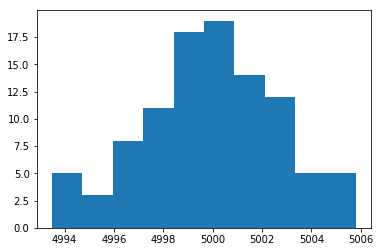

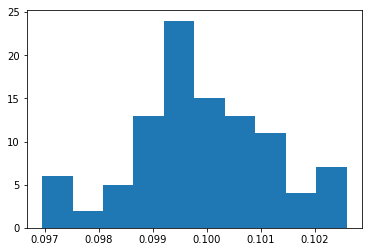

In [8]:
plt.figure()
plt.hist(x)
plt.figure()
plt.hist(v)

In [9]:
rms, bias, _, x, v = simu (r, sources, Nmc, t_e, True, pmap, x0=None)

In [10]:
rms

24.15238162125325

(array([ 7.,  7., 12., 29., 22., 16.,  5.,  1.,  0.,  1.]),
 array([4988.72205951, 4991.73901008, 4994.75596066, 4997.77291123,
        5000.78986181, 5003.80681238, 5006.82376295, 5009.84071353,
        5012.8576641 , 5015.87461468, 5018.89156525]),
 <a list of 10 Patch objects>)

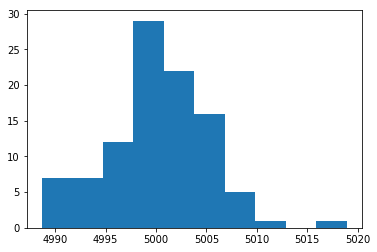

In [76]:
plt.figure()
plt.hist(x)

(array([ 7.,  7., 12., 29., 22., 16.,  5.,  1.,  0.,  1.]),
 array([4988.72205951, 4991.73901008, 4994.75596066, 4997.77291123,
        5000.78986181, 5003.80681238, 5006.82376295, 5009.84071353,
        5012.8576641 , 5015.87461468, 5018.89156525]),
 <a list of 10 Patch objects>)

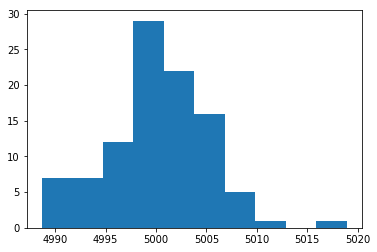

In [79]:
plt.figure()
plt.hist(x, 10)

(array([ 6.,  8., 23., 22., 12., 18.,  3.,  3.,  4.,  1.]),
 array([0.08028462, 0.08239437, 0.08450413, 0.08661388, 0.08872364,
        0.09083339, 0.09294315, 0.0950529 , 0.09716266, 0.09927241,
        0.10138217]),
 <a list of 10 Patch objects>)

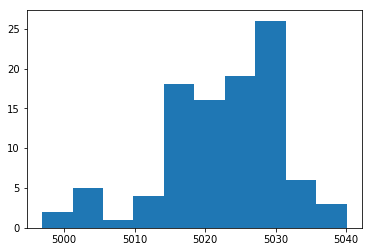

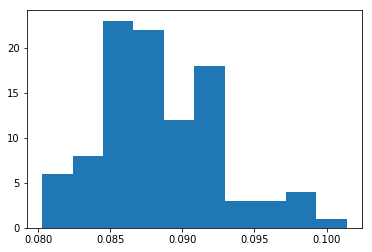

In [11]:
plt.figure()
plt.hist(x)
plt.figure()
plt.hist(v)

In [11]:
###########################################################################
########################## GRAPHES RAPPORT ################################
###########################################################################

In [12]:
Nmc=100

In [43]:
dr = np.array([0.001, 0.005, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 1., 1.5])   # dérives d'horloges
dv = np.array([1.e-5, 0.001, 0.005, 0.01, 0.1])
rms1=np.zeros((len(dr), len(dv)))

X1 = []
V1 = []
for i in range(len(dr)) :
    r.dt = np.array(0.) #dr[i]
    r.e_dt = dr[i]
    #r.draw_clock_drift(dr[i])
    _x, _v = [], []
    for j in range (len(dv)):
        r.v_x = 0.
        r.e_v = dv[j]
        #rms1[i,j], _, _, x, v = simu (r, sources, Nmc, t_e, True, pmap, x0=None)
        rms1[i,j], _, _, x, v = simu (r, sources, Nmc, t_e, True, pmap, 
                                      x0=np.array([r.x,r.v_x,r.e_dt]))
        _x.append(x)
        _v.append(v)        
    X1.append(_x)
    V1.append(_v)
    #print(r.dt, rms)

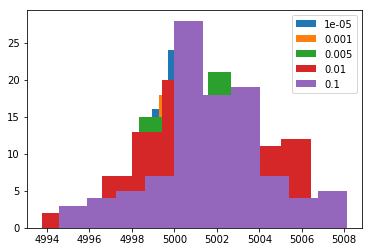

In [14]:
for x,v in zip(X[0],dv):
    plt.hist(x, label=str(v))
plt.legend()

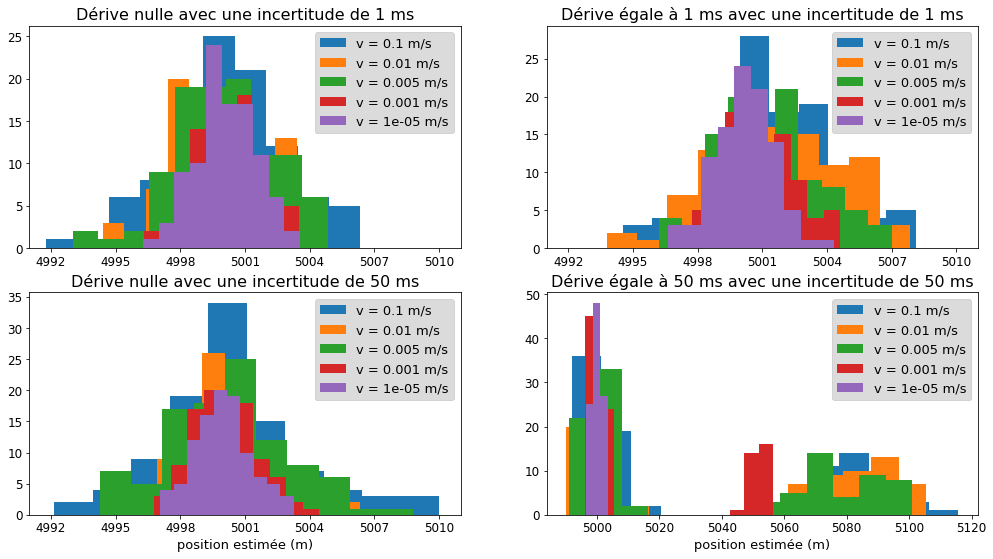

In [99]:
plt.figure(figsize=(17,9))

plt.subplot(221)
plt.hist(X1[0][4], label="v = "+str(dv[4])+" m/s")
plt.hist(X1[0][3], label="v = "+str(dv[3])+" m/s")
plt.hist(X1[0][2], label="v = "+str(dv[2])+" m/s")
plt.hist(X1[0][1], label="v = "+str(dv[1])+" m/s")
plt.hist(X1[0][0], label="v = "+str(dv[0])+" m/s")

plt.legend(fontsize=13, facecolor='lightgrey')
plt.title ('Dérive nulle avec une incertitude de 1 ms', fontsize=16)
#plt.xlabel('position du flotteur (m)', fontsize=14)

plt.xticks(np.arange(4992, 5011, step=3.), fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([4991.,5011.])


plt.subplot(222)
plt.hist(X[0][4], label="v = "+str(dv[4])+" m/s")
plt.hist(X[0][3], label="v = "+str(dv[3])+" m/s")
plt.hist(X[0][2], label="v = "+str(dv[2])+" m/s")
plt.hist(X[0][1], label="v = "+str(dv[1])+" m/s")
plt.hist(X[0][0], label="v = "+str(dv[0])+" m/s")

plt.legend(fontsize=13, facecolor='lightgrey')
plt.title ('Dérive égale à 1 ms avec une incertitude de 1 ms', fontsize=16)
#plt.xlabel('position du flotteur (m)', fontsize=14)
plt.xticks(np.arange(4992, 5011, step=3.), fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([4991.,5011.])

plt.subplot(223)
plt.hist(X1[4][4], label="v = "+str(dv[4])+" m/s")
plt.hist(X1[4][3], label="v = "+str(dv[3])+" m/s")
plt.hist(X1[4][2], label="v = "+str(dv[2])+" m/s")
plt.hist(X1[4][1], label="v = "+str(dv[1])+" m/s")
plt.hist(X1[4][0], label="v = "+str(dv[0])+" m/s")

plt.legend(fontsize=13, facecolor='lightgrey')
plt.title ('Dérive nulle avec une incertitude de 50 ms', fontsize=16)
plt.xlabel('position estimée (m)', fontsize=13)
plt.xticks(np.arange(4992, 5011, step=3.), fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([4991.,5011.])

plt.subplot(224)
plt.hist(X[4][4], 13, label="v = "+str(dv[4])+" m/s")
plt.hist(X[4][3], 13, label="v = "+str(dv[3])+" m/s")
plt.hist(X[4][2], 13, label="v = "+str(dv[2])+" m/s")
plt.hist(X[4][1], 13, label="v = "+str(dv[1])+" m/s")
plt.hist(X[4][0], 3, label="v = "+str(dv[0])+" m/s")

plt.legend(fontsize=13, facecolor='lightgrey')
plt.title ('Dérive égale à 50 ms avec une incertitude de 50 ms', fontsize=16)
plt.xlabel('position estimée (m)', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.savefig('histogrammes', dpi=100)

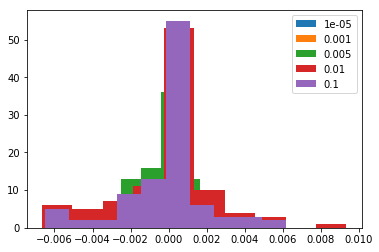

In [33]:
for vv, v in zip(V[6], dv):
    plt.hist(vv, label=str(v))
plt.legend()